<html>
<h3>Removing top layer of efficient net and loading our own classification layer</h3>

references:<br>
<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/">Tensorflow Documentation - Layers</a><br>
<a href="https://arxiv.org/pdf/1905.11946.pdf">Efficient Net and how it works</a><br>
<a href="https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/">Keras example for fine tuning</a><br>
<a href="https://www.tensorflow.org/guide/keras/train_and_evaluate">Tensorflow Documentation - Compiling and Evaluating</a><br>
<a href="https://keras.io/api/optimizers/">Keras Documentation - Optimisers</a><br>
<a href="https://keras.io/api/metrics/">Keras Documentation - Metrics</a><br>
<a href="https://keras.io/api/losses/">Keras Documentation - Losses</a><br>
<a href="https://keras.io/api/preprocessing/image/">Keras Documentation - Image Preprocess</a><br>
</html>

In [1]:
# importing required packages

from tensorflow.keras.applications import EfficientNetB0 as enet
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import ResizeMethod

import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from tensorflow import io
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd

# for model plot
from tensorflow.keras.utils import plot_model

# for image sampling
import os
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

%matplotlib inline

In [2]:

# Setup constants and global parameters
train_folder = "../data/training"
validation_folder = "../data/validation"
eval_folder = "../data/evaluation"
save_folder = "../data/saved"
test_folder = "../data/test"

height = 224
width = 224
num_train = 3200
num_valid = 400
batch_size = 24
v_batch_size = 12
t_batch_size = 6
epochs_to_run = 10
learning_rate = 2e-2
seed = 55    # to sample same augmented images
max_sample = 9    # max sampling must be perfect square  i.e. 9, 16, 25 etc.
fig_size = 8

In [3]:
# Display N x N grid of image set

def show_grid(x_generate, count, title):

    grid = round(math.sqrt(count))
    
    plt.figure(figsize=(fig_size,fig_size))
    for i in range(0,count):
        batch = x_generate.next()
        ax = plt.subplot(grid, grid, i + 1)
        image = batch[0][0].astype('uint8')
        #print(batch[1][0][0])
        if batch[1][0][0] > batch[1][0][1]:
            plt.title("With Mask")
        else:
            plt.title("Without Mask")
        plt.tight_layout()
        plt.imshow(image)
    
    # show the plot
    plt.show()

In [4]:
# plot function parking lot

# kelvin's beautifully written plot function
def plot_hist(hist, measure):
    v_measure = "val_" + measure

    plt.plot(hist.history[measure])
    plt.plot(hist.history[v_measure])
    plt.title("model " + measure)
    plt.ylabel(measure)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    #plt.show()

# arranging the graphs using kelvin functions
def plot_graphs(*args):
    i = 1
    plt.figure(figsize=(10, 3))
    for arg in args:
        ax = plt.subplot(1, len(args), i)
        i += 1
        plot_hist(history, arg)
    
    plt.show()


In [5]:
# loading pretrained model, setting input shape
inputs = (224, 224, 3)

# Selecting a topless model (sounds damn good...)
basemodel = enet(include_top=False, input_shape=inputs, weights="imagenet")

# locking the trained weights (freezing?)
basemodel.trainable = False 

# checking out how its like
basemodel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [6]:
# plot_model(basemodel, to_file='model.png',show_shapes=True, show_layer_names=True)

In [7]:
# to rebuild top layer for our own classification

dropout_rate = 0.5 #i_dunno_yet - supposed to prevent overfit
types = 2 #currently only mask and no mask 

# building up the model in sequence
model = models.Sequential()

# loading the original topless model
model.add(basemodel)

# adding top layers 
model.add(layers.GlobalMaxPooling2D(name="gap"))

model.add(layers.Dropout(dropout_rate, name="drout"))

model.add(layers.Dense(types, activation="softmax", name="classdense"))

# view the assembled model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
drout (Dropout)              (None, 1280)              0         
_________________________________________________________________
classdense (Dense)           (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


In [8]:
# Display model layers
#plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True, rankdir ="LR")

Found 1600 images belonging to 2 classes.
TRAINING SET: Sampling original training images ...


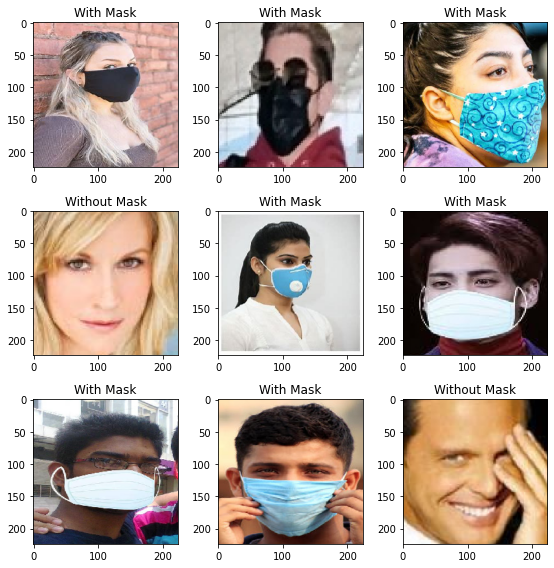

In [9]:
# display training images in original format

orig_tf = ImageDataGenerator()

# using keras image generator, disable save_to_dir if not required
orig_generate = orig_tf.flow_from_directory(train_folder, target_size = (height, width), #save_to_dir = save_folder,
                                              shuffle = True, batch_size = batch_size, class_mode="categorical", seed = seed)
print("TRAINING SET: Sampling original training images ...")
show_grid(orig_generate, max_sample, True)

Found 1600 images belonging to 2 classes.
TRAINING SET: Sampling augmented training images ...


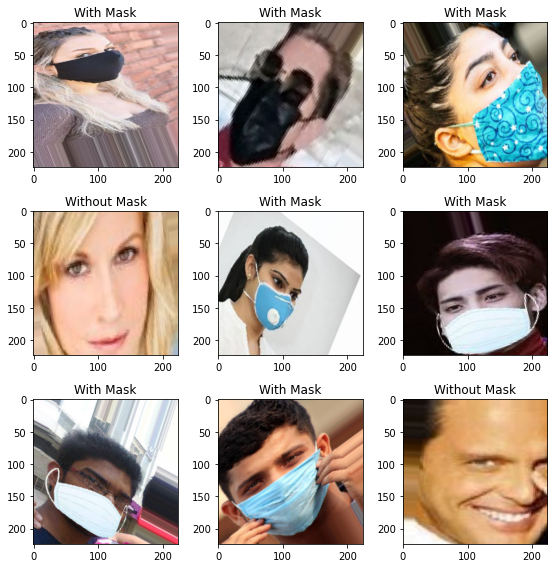

In [10]:
# augment training image set

data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=35,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.3)

train_tf = ImageDataGenerator(**data_gen_args)

# using keras image generator, disable save_to_dir if not required
train_generate = train_tf.flow_from_directory(train_folder, target_size = (height, width), #save_to_dir = save_folder,
                                              shuffle = True, batch_size = batch_size, class_mode="categorical", seed = seed)

print("TRAINING SET: Sampling augmented training images ...")
show_grid(train_generate, max_sample, True)

Found 400 images belonging to 2 classes.
VALIDATION SET: Sampling validation images ...


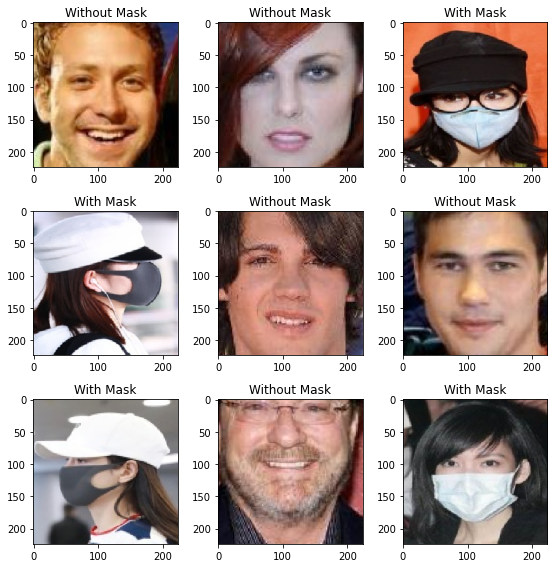

In [11]:
# prepare validation data set for training using Keras `fit` mathod for model training

validate_tf = ImageDataGenerator()

validate_generate = validate_tf.flow_from_directory(validation_folder, target_size = (height, width), shuffle = True, batch_size = v_batch_size, class_mode="categorical")

print("VALIDATION SET: Sampling validation images ...")
show_grid(validate_generate, max_sample, True)


In [12]:
print("Commpiling model ... ")
model.compile(loss="categorical_crossentropy", optimizer = keras.optimizers.Adam(lr=learning_rate), metrics = ["accuracy"])

print("Fitting model ... ")
history = model.fit(train_generate, epochs = epochs_to_run, batch_size = batch_size,
                    validation_data = validate_generate, validation_steps = v_batch_size)

Commpiling model ... 
Fitting model ... 
Epoch 1/10
67/67 [==============================] - 72s 1s/step - loss: 5.1199 - accuracy: 0.8378 - val_loss: 0.1742 - val_accuracy: 0.9861
Epoch 2/10
67/67 [==============================] - 63s 937ms/step - loss: 0.4844 - accuracy: 0.9814 - val_loss: 0.0852 - val_accuracy: 0.9931
Epoch 3/10
67/67 [==============================] - 60s 886ms/step - loss: 0.1313 - accuracy: 0.9916 - val_loss: 1.2245 - val_accuracy: 0.9514
Epoch 4/10
67/67 [==============================] - 57s 851ms/step - loss: 0.3466 - accuracy: 0.9911 - val_loss: 0.4692 - val_accuracy: 0.9722
Epoch 5/10
67/67 [==============================] - 57s 848ms/step - loss: 0.3969 - accuracy: 0.9841 - val_loss: 0.4906 - val_accuracy: 0.9722
Epoch 6/10
67/67 [==============================] - 57s 848ms/step - loss: 0.3987 - accuracy: 0.9852 - val_loss: 0.6687 - val_accuracy: 0.9861
Epoch 7/10
67/67 [==============================] - 57s 848ms/step - loss: 0.3627 - accuracy: 0.9863 - v

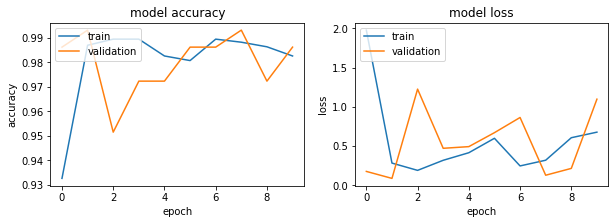

In [13]:
# show accuracy and loss curves

plot_graphs("accuracy", "loss")

Found 24 images belonging to 2 classes.
Sampling evaluation images ...


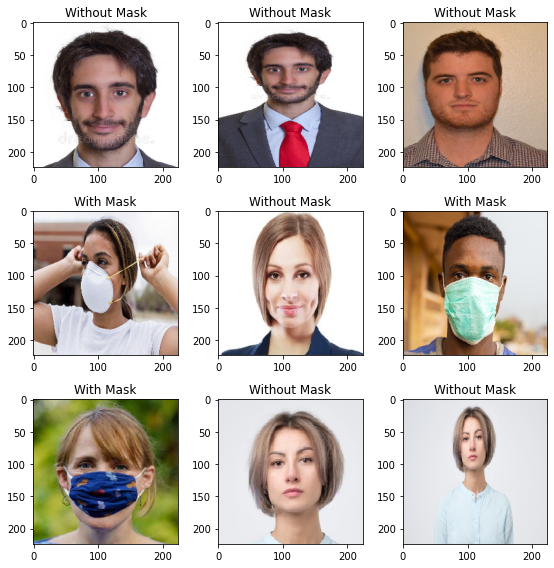

In [14]:
# prepare to evaluate the model on new evaluation data using Keras `evaluate` mathod for model training
eval_tf = ImageDataGenerator()

eval_generate = eval_tf.flow_from_directory(eval_folder, target_size = (height, width), 
                                            shuffle = True, batch_size = t_batch_size, class_mode="categorical")

print("Sampling evaluation images ...")
show_grid(eval_generate, max_sample, True)

In [15]:
print("EVALUATION SET: Perform Evaluation on evaluation data set")
results = model.evaluate(eval_generate)
print("EVALUATION METRICS: Test loss, Accuracy:", results, "\r")

EVALUATION SET: Perform Evaluation on evaluation data set
4/4 [==============================] - 1s 211ms/step - loss: 1.8703 - accuracy: 0.9583
EVALUATION METRICS: Test loss, Accuracy: [1.8702621459960938, 0.9583333134651184] 


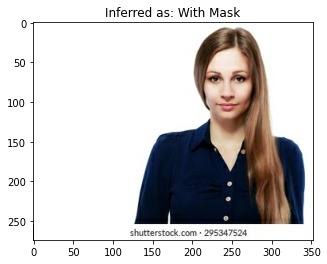

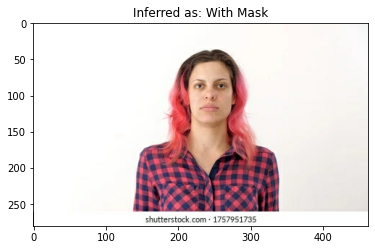

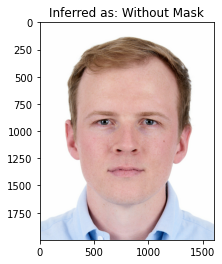

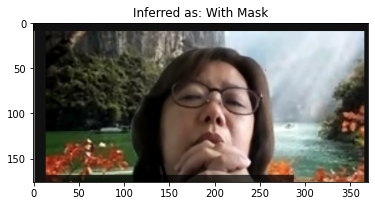

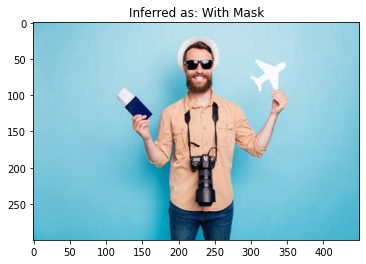

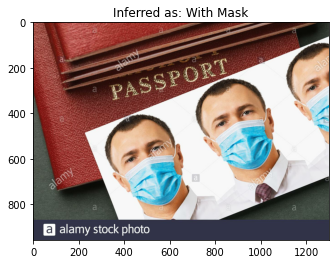

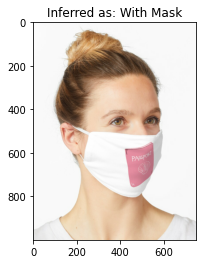

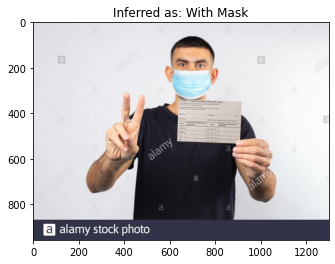

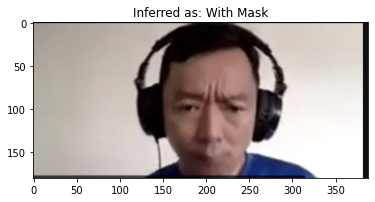

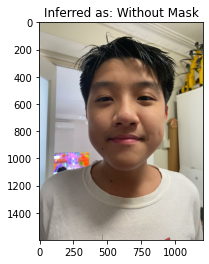

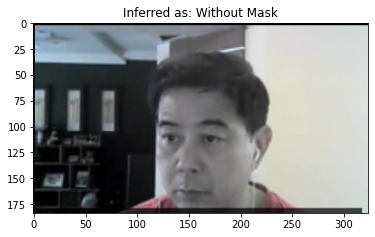

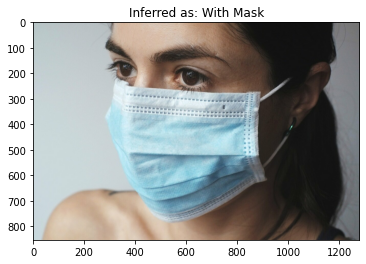

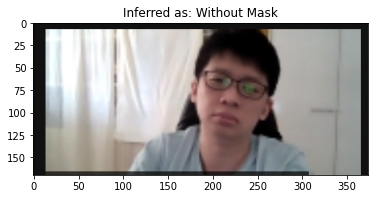

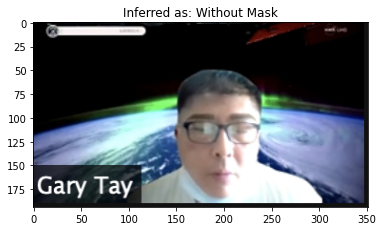

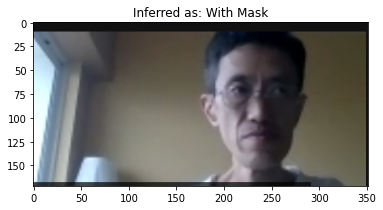

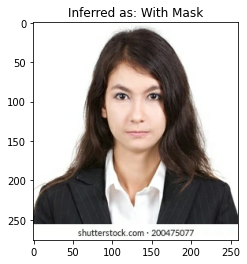

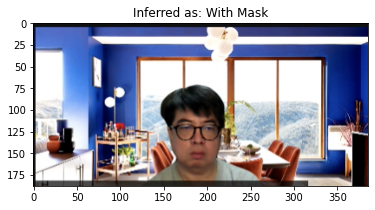

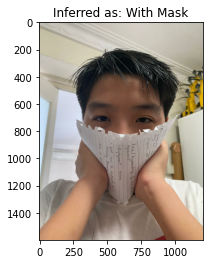

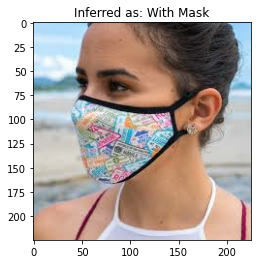

In [16]:

predict_folder = "../data/test/_testdata"

for pic in os.listdir(predict_folder):
        image = os.path.join(predict_folder, pic)
        image = io.read_file(image)
        image = io.decode_image(image, channels = 3, expand_animations = False)
        plt.imshow(image)
        image = tf.expand_dims(image, axis=0)
        image = tf.image.resize(image, (224, 224))
        pred = model.predict(image)
        if model.predict_classes(image) == 0:
            plt.title("Inferred as: With Mask")
        else: 
            plt.title("Inferred as: Without Mask")
        plt.show()


In [22]:
# to do - pack and export model for deploy/online predictions
#!pip install pyyaml h5py
model_name = "effnetalpha"

model_save_path = os.path.join(save_folder, model_name)

model.save(model_save_path)

model.save(f"{model_save_path}/{model_name}.h5")
# model.save(f"{save_folder}/{model_name}.h5")

INFO:tensorflow:Assets written to: ../data/saved/effnetalpha/assets
